Button(description='Generate data', style=ButtonStyle())

Button(description='Cluster data', style=ButtonStyle())

<IPython.core.display.Javascript object>


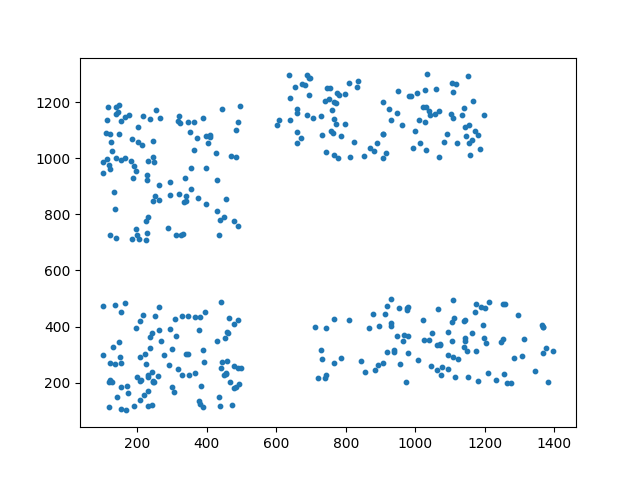

<IPython.core.display.Javascript object>


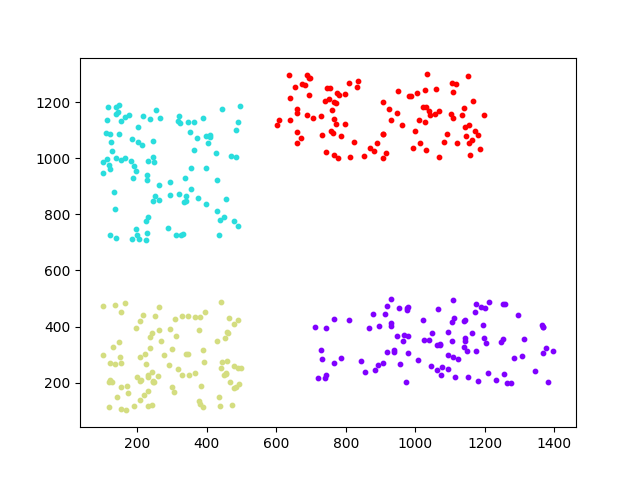

In [10]:
import os

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from IPython.display import display
from ipywidgets import widgets

%matplotlib notebook

generate_data_button = widgets.Button(description="Generate data")
cluster_data_button = widgets.Button(description="Cluster data")

generated_data = []
clustered_data = []
cluster_num = 4
bounds = [[100, 500],[100, 500],[700, 1400],[200, 500],[100, 500],[700, 1200],[600,1200],[1000, 1300]]
display(generate_data_button)
display(cluster_data_button)

generated_figure = plt.figure(num='Generated Data')
clustered_figure = plt.figure(num='Clustered Data')
generated_ax = generated_figure.add_subplot(111)
clustered_ax = clustered_figure.add_subplot(111)

plt.ion()

generated_figure.show()
generated_figure.canvas.draw()
clustered_figure.show()
clustered_figure.canvas.draw()

def get_host():
    host = os.getenv("ENV_KMEANS_BACKEND_HOST")
    if not host:
        host = "localhost"
    return host

def get_port():
    port = os.getenv("ENV_KMEANS_BACKEND_PORT")
    if not port:
        port = 11111
    return port


def generate_data(b):
    global generated_data
    host = get_host()
    port = get_port()
    url = 'http://{}:{}/generatedata'.format(host, port)
    headers = {'Content-Type':'application/json'}
    body = {'clusterNum': cluster_num,'bounds': bounds}
    response = requests.post(url, json=body, headers=headers)
    generated_data = response.json()['data']
    show_generated_data(generated_data)


def cluster_data(b):
    global clustered_data
    global generated_data
    host = get_host()
    port = get_port()
    url = 'http://{}:{}/clusterdata'.format(host, port)
    type = "KMEANS"
    body = {'type':type, 'clusterNum':cluster_num, 'data':generated_data}
    headers = {'Content-Type':'application/json'}
    response = requests.post(url, json=body, headers=headers)
    clustered_data = response.json()['clusteredData']
    show_clustered_data(clustered_data)

def split_to_clusters(df):
    clusters_indexes = df['cluster'].unique()
    res = {}
    for ci in clusters_indexes:
        res[ci] = df[df['cluster'] == ci]
    return res


def show_clustered_data(data):
    global clustered_figure
    global clustered_ax
    df = pd.DataFrame(data, columns =['x', 'y', 'cluster'], dtype = int)
    clusters = split_to_clusters(df)
    colors = cm.rainbow(np.linspace(0, 1, len(clusters)))
    clustered_ax.clear()
    for cluster in clusters:
        points = clusters[cluster]
        clustered_ax.scatter(x=points['x'],
                             y=points['y'],
                             s=10,
                             color=colors[cluster],
                             label='Clustered data')
    clustered_figure.canvas.draw()

def show_generated_data(data):
    global generated_figure
    global generated_ax
    df = pd.DataFrame(data, columns =['x', 'y'], dtype = int)
    generated_ax.clear()
    generated_ax.scatter(x=df['x'],
                        y=df['y'],
                        s=10,
                        label='Generated data')
    generated_figure.canvas.draw()

generate_data_button.on_click(generate_data)
cluster_data_button.on_click(cluster_data)
